#IMPORTS


In [236]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm 
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats 
from scipy.special import inv_boxcox

#CSV TREATMENTS

In [237]:
dataFrame = pd.read_csv('musicdata.csv', index_col=0) # carrega o CSV

dataFrame = dataFrame[dataFrame['value_actual'].notna()] # remove os valores negativos

dataFrame = dataFrame.query("format=='CD' and metric=='Value'") #filtra o dataset por CD

dataFrame = dataFrame.set_index("year") # define a coluna year como index

dataFrame = dataFrame.drop(['metric','number_of_records'],axis=1) # remove as colunas "metric, number_of_records"

dataFrame = dataFrame.sort_values(by=['year']) # ordena o dataFrame do menor ano para o maior


#VISUAL CHART

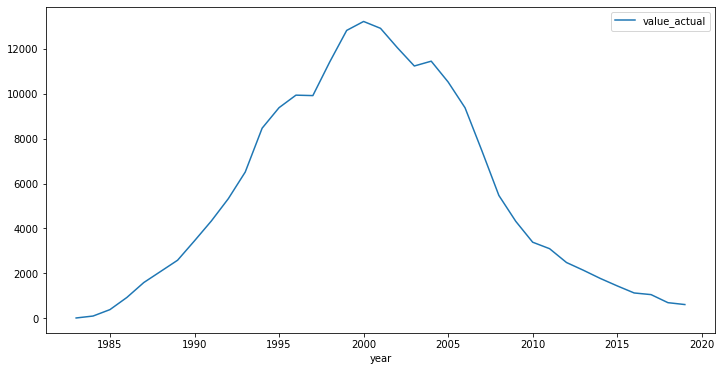

In [238]:
dataFrame.plot(figsize=(12,6))
plt.show()

#DESCRIPTION


In [239]:
dataFrame.describe()

,value_actual
count,37.000000
mean,5542.809705
std,4463.158244
min,17.200000
25%,1593.600000
50%,4318.800000
75%,9915.100000
max,13214.500000


#NORMALITY TEST KSTEST


In [240]:
stats.kstest(dataFrame['value_actual'],'norm')

KstestResult(statistic=1.0, pvalue=0.0)

In [241]:
statistic, pvalue = stats.kstest(dataFrame['value_actual'],'norm')

if pvalue > 0.29407:
  print('Não é uma distribuição normal')
else: 
  print('É uma distribuição normal')


É uma distribuição normal


#NORMALITY TEST SHAPIRO - SW


In [243]:
print(stats.shapiro(dataFrame['value_actual'])) # verificando a variancia sem a aplicação do boxcox
if stats.shapiro(dataFrame['value_actual'])[1]> 0.05:
    print('Distribuição Normal')
else:
    print('Não é uma Distribuição Normal')

ShapiroResult(statistic=0.887243926525116, pvalue=0.0013277996331453323)
Não é uma Distribuição Normal


#BOX COX

In [244]:
newValue, lambda_boxcox = stats.boxcox(dataFrame['value_actual']) # reduzindo a variancia para conseguir uma curva mais normal
newValue

array([  5.38585142,  13.86616626,  25.63761698,  37.65898639,
        47.54921018,  53.4177652 ,  58.5238699 ,  66.15505302,
        72.88209832,  79.48842557,  86.51049579,  96.59551802,
       100.83658637, 103.30665858, 103.22119596, 109.49814411,
       114.92814006, 116.40760498, 115.27644702, 111.9797643 ,
       108.75959973, 109.62048626, 105.81507994, 100.81494017,
        91.56397848,  80.39305079,  72.74756068,  65.64624873,
        63.20932335,  57.52749624,  53.97206129,  49.82006165,
        45.58534055,  40.99800196,  39.81997736,  33.22047454,
        31.4004719 ])

In [245]:
print(stats.shapiro(newValue)) # executa o shapiro com os valores retornados pelo boxcox

ShapiroResult(statistic=0.9418991208076477, pvalue=0.053019385784864426)


In [246]:
#verifica se apos o boxcox a distribuição ficou normal
print(stats.shapiro(newValue))
if stats.shapiro(newValue)[1]> 0.05:
    print('Distribuição Normal')
else:
    print('Não é uma Distribuição Normal')

ShapiroResult(statistic=0.9418991208076477, pvalue=0.053019385784864426)
Distribuição Normal


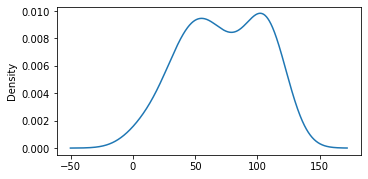

In [247]:
normalValues = pd.DataFrame(newValue, columns=['value_actual'])

#prova que a curva se tornou mais próxima de uma normal
plt.subplot(222)
normalValues.value_actual.plot(kind='kde', figsize=(12,6))
plt.show()

#MAP


In [230]:
dataMaped = []

def appendItem(downloadData): # adiciona no array a informação mapeada
  dataMaped.append({"year": downloadData[2],"value": downloadData[4]}) 

def map(data):  #mapeia as informações checando se os campos são os escolhidos
  for downloadData in data :
    if downloadData[0] == "Download Single" and downloadData[1] == "Value":
      appendItem(downloadData) 
    elif downloadData[0] == "Download Music Video" and downloadData[1] == "Value":
      appendItem(downloadData)
    elif downloadData[0] == "Download Album" and downloadData[1] == "Value":
      appendItem(downloadData)

  return dataMaped

#FILTER / REDUCER 

In [231]:
dataReduced = []

def reducer(dataMaped):
  for downloadData in dataMaped: #percorre o array mapeado
    isEquals = False  

    for i in range(len(dataReduced)): # percorre o array reduzido
      if dataReduced[i]["year"] == downloadData["year"]: # caso os anos sejam iguais, define a variavel isEquals como true
        isEquals = True
        break 
    
    if isEquals: # se for True soma o valor anterior com o atual
      dataReduced[i] = { "year": dataReduced[i]["year"], "value": dataReduced[i]["value"] + downloadData["value"] }
    else:
      dataReduced.append(downloadData) # se for False adiciona o novo valor

  return dataReduced

#MAP RUN

In [232]:
#TRATAMENTOS CSV

dataFrame = pd.read_csv('musicdata.csv', index_col=0) # carrega o CSV
dataFrame = dataFrame[dataFrame['value_actual'].notna()] # remove os valores negativos
dataFrame = dataFrame.sort_values(by=['year']) # ordena o dataFrame do menor ano para o maior

In [233]:
#EXECUÇÃO

data = dataFrame.reset_index().to_numpy() # converte para ser possivel percorrer no map
dataMaped = map(data) #faz a função de mapeamento
dataReduced = reducer(dataMaped) #faz a função de reducer

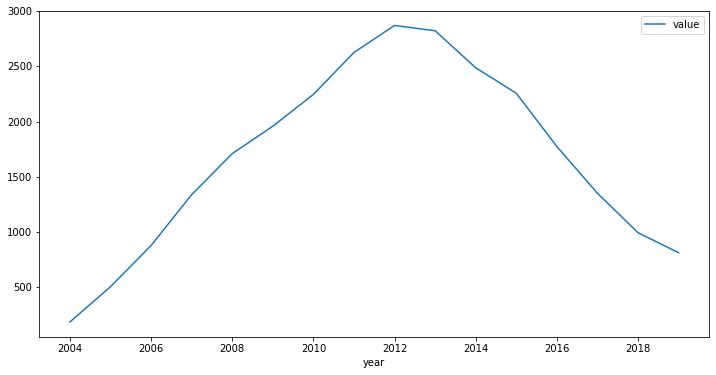

In [234]:
#EXIBIÇÃO
dataReduced = pd.DataFrame(dataReduced, columns = ['year','value']) 
dataReduced = dataReduced.set_index('year')
dataReduced.plot(figsize=(12,6))
plt.show()